In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers,callbacks
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print(tf.__version__)

2.15.0


### Impprting the Tensorflow Dataset for Preprocessing

In [4]:
# Intializing Constants
Batch_Size=32
Image_Size=256

Channels=3 #For RGB Purposes

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "drive/MyDrive/PlantVillage1",
    shuffle=True,
    image_size=(Image_Size,Image_Size),
    batch_size=Batch_Size
)

Found 8619 files belonging to 10 classes.


### Check the Class Names (Basically Folder Names -> Class Names)

In [6]:
class_Names = dataset.class_names
class_Names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

#### A point to Note

#### If we use the Function **len** what should be our output and why ?

In [7]:
len(dataset)

270

#### Answer
<details>>
Here our dataset is processing i.e*Loading the Image* in batch size of 32 images each batch hence the dataset length is5011, with total data points however as5011*3n

</details>

### Exploring the dataset

In [8]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[8 7 7 7 5 7 6 7 8 7 6 6 6 6 3 4 8 7 7 4 7 3 5 7 4 4 7 6 4 4 7 7]


#### Details of the above output
<details>
  <summary><h4><strongDetails1</strong></h4></summary>
32 - refers to the batch size
256,256 - refers to each image size
3 - refers to the channels (Colors R,G,B)
the array refers to the 3 classes that are mentoned above in the class nameson.

</details>

### let's Visualize some of the images from our dataset

Enter the number of images you want to see from a batch with limit as 32 currently from a single batch6


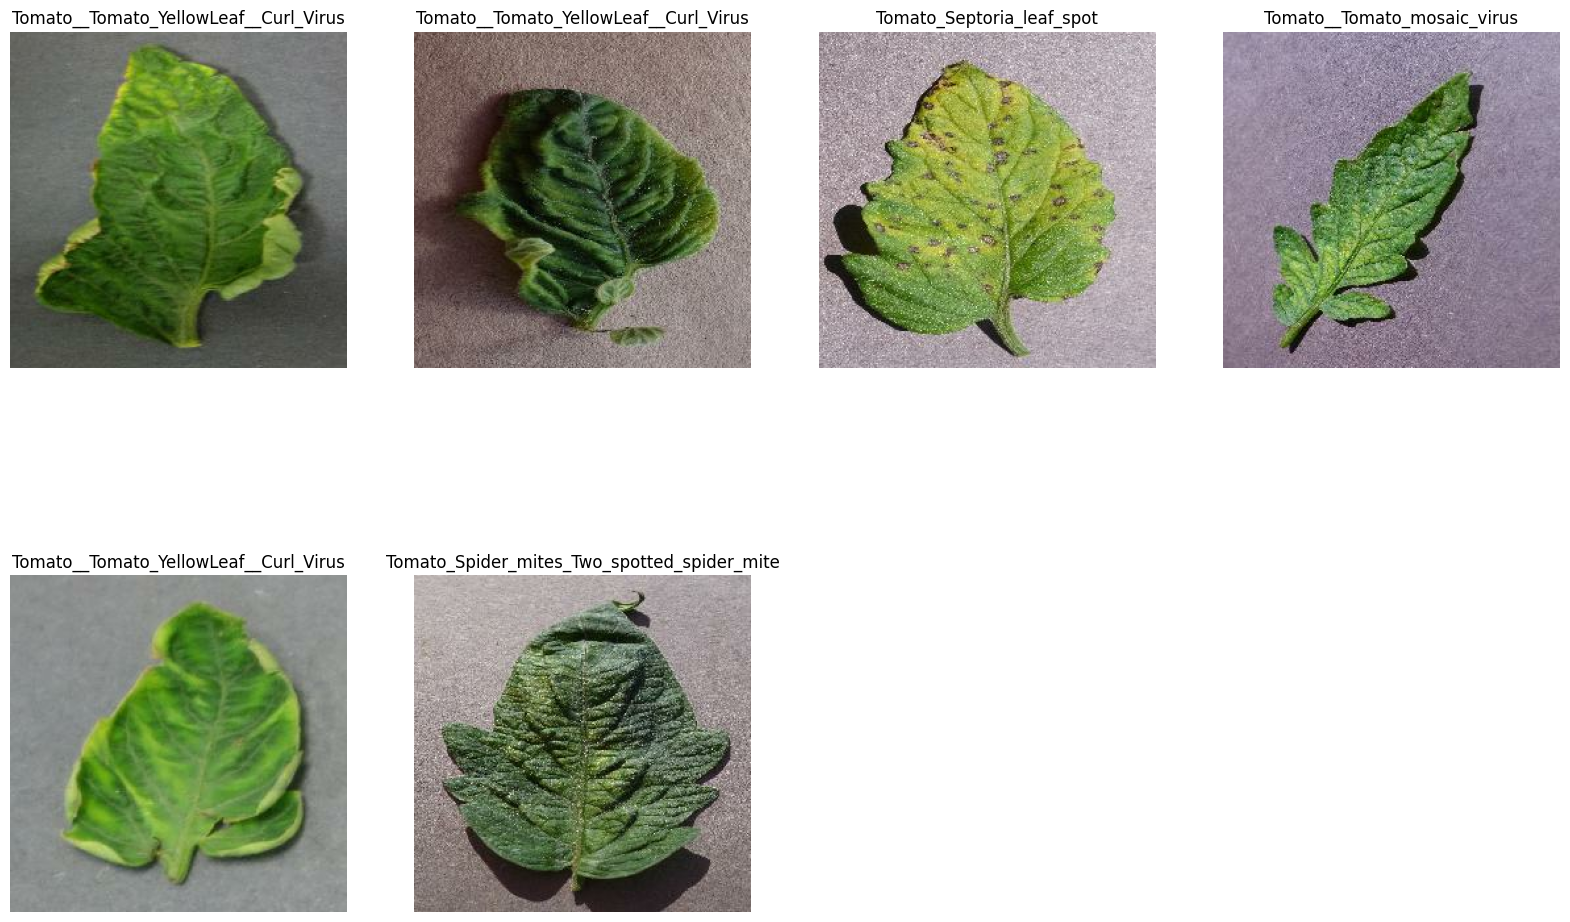

In [9]:
n = int(input ("Enter the number of images you want to see from a batch with limit as 32 currently from a single batch"))
plt.figure(figsize=(20,20))
for image_batch, label_batch in dataset.take(1):
    for i in range(n):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_Names[label_batch[i]])
        plt.axis("off")

### Now we will split our dataset into Training and Test sets

#### We will do a 80-10-10 Split
<details>
    80 - Refers to the training set
    10 - Refers to the Validation set where we will validate our models' learnings
    10 - Will be the Test set to test our models' performance
</details>

### Defining the number of Epochs initially to **40** (Trial and Error)

In [10]:
Epochs=50

In [11]:
train_size = 0.8 #80%
len(dataset) * train_size

216.0

In [12]:
train_ds = dataset.take(400)
len(train_ds)

270

#### Test Dataset

In [13]:
test_ds = dataset.skip(400) # This skips the first 112 dataset just opposite to the above
len(test_ds)

0

<details>
Further we will split above dataset into 2 parts as Validation and Test
</details>

In [14]:
len(dataset)*0.1

27.0

In [15]:
validation_ds = test_ds.take(50)
len(validation_ds)

0

In [16]:
Test_dataset=test_ds.skip(50)
len(Test_dataset)

0

### Combining the above Harcoded Procedure into a single dynamic Function

In [17]:
def get_dataset_partitions_tf(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):

    if shuffle:
        dataset=dataset.shuffle(shuffle_size,seed=12)
    train_size=int(len(dataset)*train_split)
    train_dataset=dataset.take(train_size)

    validation_size=int(len(dataset)*val_split)
    validation_dataset=dataset.skip(train_size).take(validation_size)

    test_dataset = dataset.skip(train_size).skip(validation_size)

    return train_dataset,validation_dataset,test_dataset

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

216

In [20]:
len(val_ds)

27

In [21]:
len(test_ds)

27

### now we will perform caching on the dataset

<details>
    Assuming that we might need an image froma a batch again in another batch while model training concept , the concept of **caching** will help us retain that image by **storing it in the memory** in that particular image's first iteration.
</details>

In [22]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<details>
    Prefetch here helps reduce computation time -> if a GPU is training on the model, then prefetch will Load the next batch data in the CPU
</details>

### Now we will do some data Preprocessing 1) Resize all images to 256 X 256 2) scale the image between 0 to 1 which is currently Between 0 to 255 range

In [23]:
Resize_Rescale = tf.keras.Sequential([
    layers.Resizing(Image_Size,Image_Size),
    layers.Rescaling(1./255)
])

#### Now We will perform Data Augmentation
<details>
    Here let's assume we get a rotated image or a contrasted image then in tht case the model might face issue in the trining segment, hence to reduce this we will need to perform data augmentation
</details>

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

## Model Building using Convolutional Neural Network (CNN)

In [25]:
input_shape=(32,Image_Size,Image_Size,Channels)
n_classes = 9

model = models.Sequential([
    Resize_Rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

### Before Compiling Our Model Let us build an early stopping Parameter

<details>
    While building our model we have decided on a fixed number of epochs however there might be cases when even before the user desired epoch has been reached there begins the case of loss of accuracy in that we must stop furthere training to maintain the robustness and accuracy of our model. In the case at hand we will do the same keeping a patience of 5 which means that if regularly there are 5 iteration where there is loss in validation data we will stop further training of our model.
</details>

In [27]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

### We will compile our model

In [28]:
model.compile(
    optimizer='adam',
    metrics=['accuracy'],
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
)

In [40]:
history=model.fit(
    train_ds,
    epochs=Epochs,
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_ds,
    callbacks=early_stopping
)

Epoch 1/50
216/216 [==============================] - 107s 495ms/step - loss: 0.1820 - accuracy: 0.9356 - val_loss: 0.1596 - val_accuracy: 0.9454
Epoch 2/50
216/216 [==============================] - 107s 496ms/step - loss: 0.1474 - accuracy: 0.9480 - val_loss: 0.1318 - val_accuracy: 0.9561
Epoch 3/50
216/216 [==============================] - 108s 498ms/step - loss: 0.1155 - accuracy: 0.9602 - val_loss: 0.1528 - val_accuracy: 0.9359
Epoch 4/50
216/216 [==============================] - 108s 498ms/step - loss: 0.1233 - accuracy: 0.9570 - val_loss: 0.1700 - val_accuracy: 0.9288
Epoch 5/50
216/216 [==============================] - 107s 495ms/step - loss: 0.1151 - accuracy: 0.9575 - val_loss: 0.1303 - val_accuracy: 0.9585
Epoch 6/50
216/216 [==============================] - 107s 497ms/step - loss: 0.1445 - accuracy: 0.9491 - val_loss: 0.1716 - val_accuracy: 0.9407
Epoch 7/50
216/216 [==============================] - 108s 500ms/step - loss: 0.1222 - accuracy: 0.9585 - val_loss: 0.1198 -

#### Evaluating the model now on the test Set

In [41]:
scores=model.evaluate(test_ds)

27/27 [==============================] - 3s 108ms/step - loss: 0.0581 - accuracy: 0.9780


In [42]:
scores

[0.05808434262871742, 0.9780092835426331]

In [43]:
history

In [44]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 216}

In [45]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
len(history.history['loss'])

19

In [47]:
history.history['val_accuracy']

[0.9454329609870911,
 0.9561091065406799,
 0.935943067073822,
 0.9288256168365479,
 0.9584816098213196,
 0.9406880140304565,
 0.9572953581809998,
 0.935943067073822,
 0.9620403051376343,
 0.9478054642677307,
 0.9703440070152283,
 0.9608541131019592,
 0.9228944182395935,
 0.9679715037345886,
 0.9549229145050049,
 0.9489917159080505,
 0.9596678614616394,
 0.9632265567779541,
 0.9537366628646851]

### Plotting our History parameters to see how our model has progressed

In [48]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

### Plotting Accuracy vs Validation Accuracy

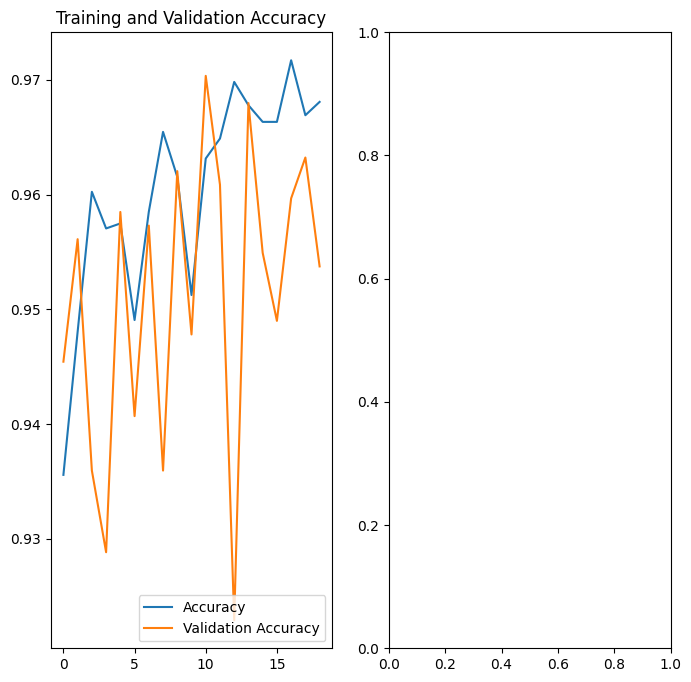

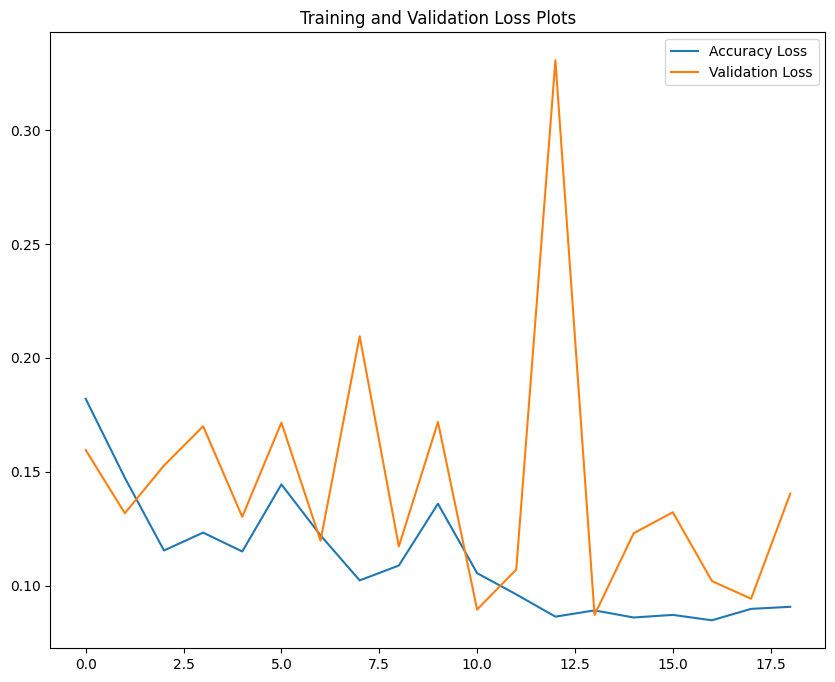

In [49]:
# %matplotlib notebook -----> Interactive Plot within the Notebook
# %matplotlib tk -----------> Plot outside the notebook

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(len(acc)), acc, label='Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# The Loss Chart
plt.subplot(1,2,2)
plt.figure(figsize=(10,8))
plt.plot(range(len(loss)), loss, label='Accuracy Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss Plots')
plt.show()

<details>
    Now if we witness the graphs we see that the initial loss is high and then it gradually decreases as the backpropagation increases.
</details>

#### Now we will make the predictions on our test dataset

First image to Predict - 
First images' actual label -  Tomato_Septoria_leaf_spot


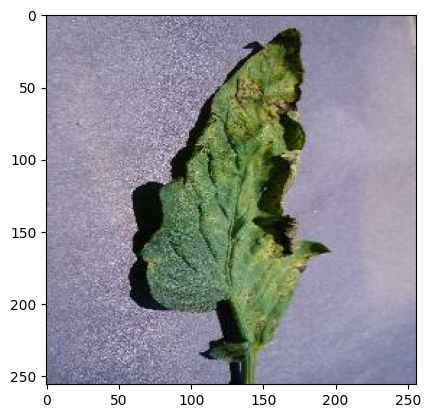

In [50]:
for image_batch,label_batch in test_ds.take(1):
    first_image=(image_batch[0].numpy().astype('uint8'))
    first_label=label_batch[0].numpy()

print("First image to Predict - ")
plt.imshow(first_image)
print("First images' actual label - ",class_Names[first_label])

### Now the Predicted Label

In [51]:
import numpy as np
batch_prediction=model.predict(image_batch)
print("Predicted Labels : ", class_Names[np.argmax(batch_prediction[0])])

1/1 [==============================] - 0s 258ms/step
Predicted Labels :  Tomato_Septoria_leaf_spot


<details>
    Now we will take the model and do a prediction with confidence here we will define a function and put in model and image to see the prediction and the confidence of the prediction
</details>

In [52]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) #creating a batch

    predictions=model.predict(img_array)
    predicted_class=class_Names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)

    return predicted_class,confidence

1/1 [==============================] - 0s 30ms/step


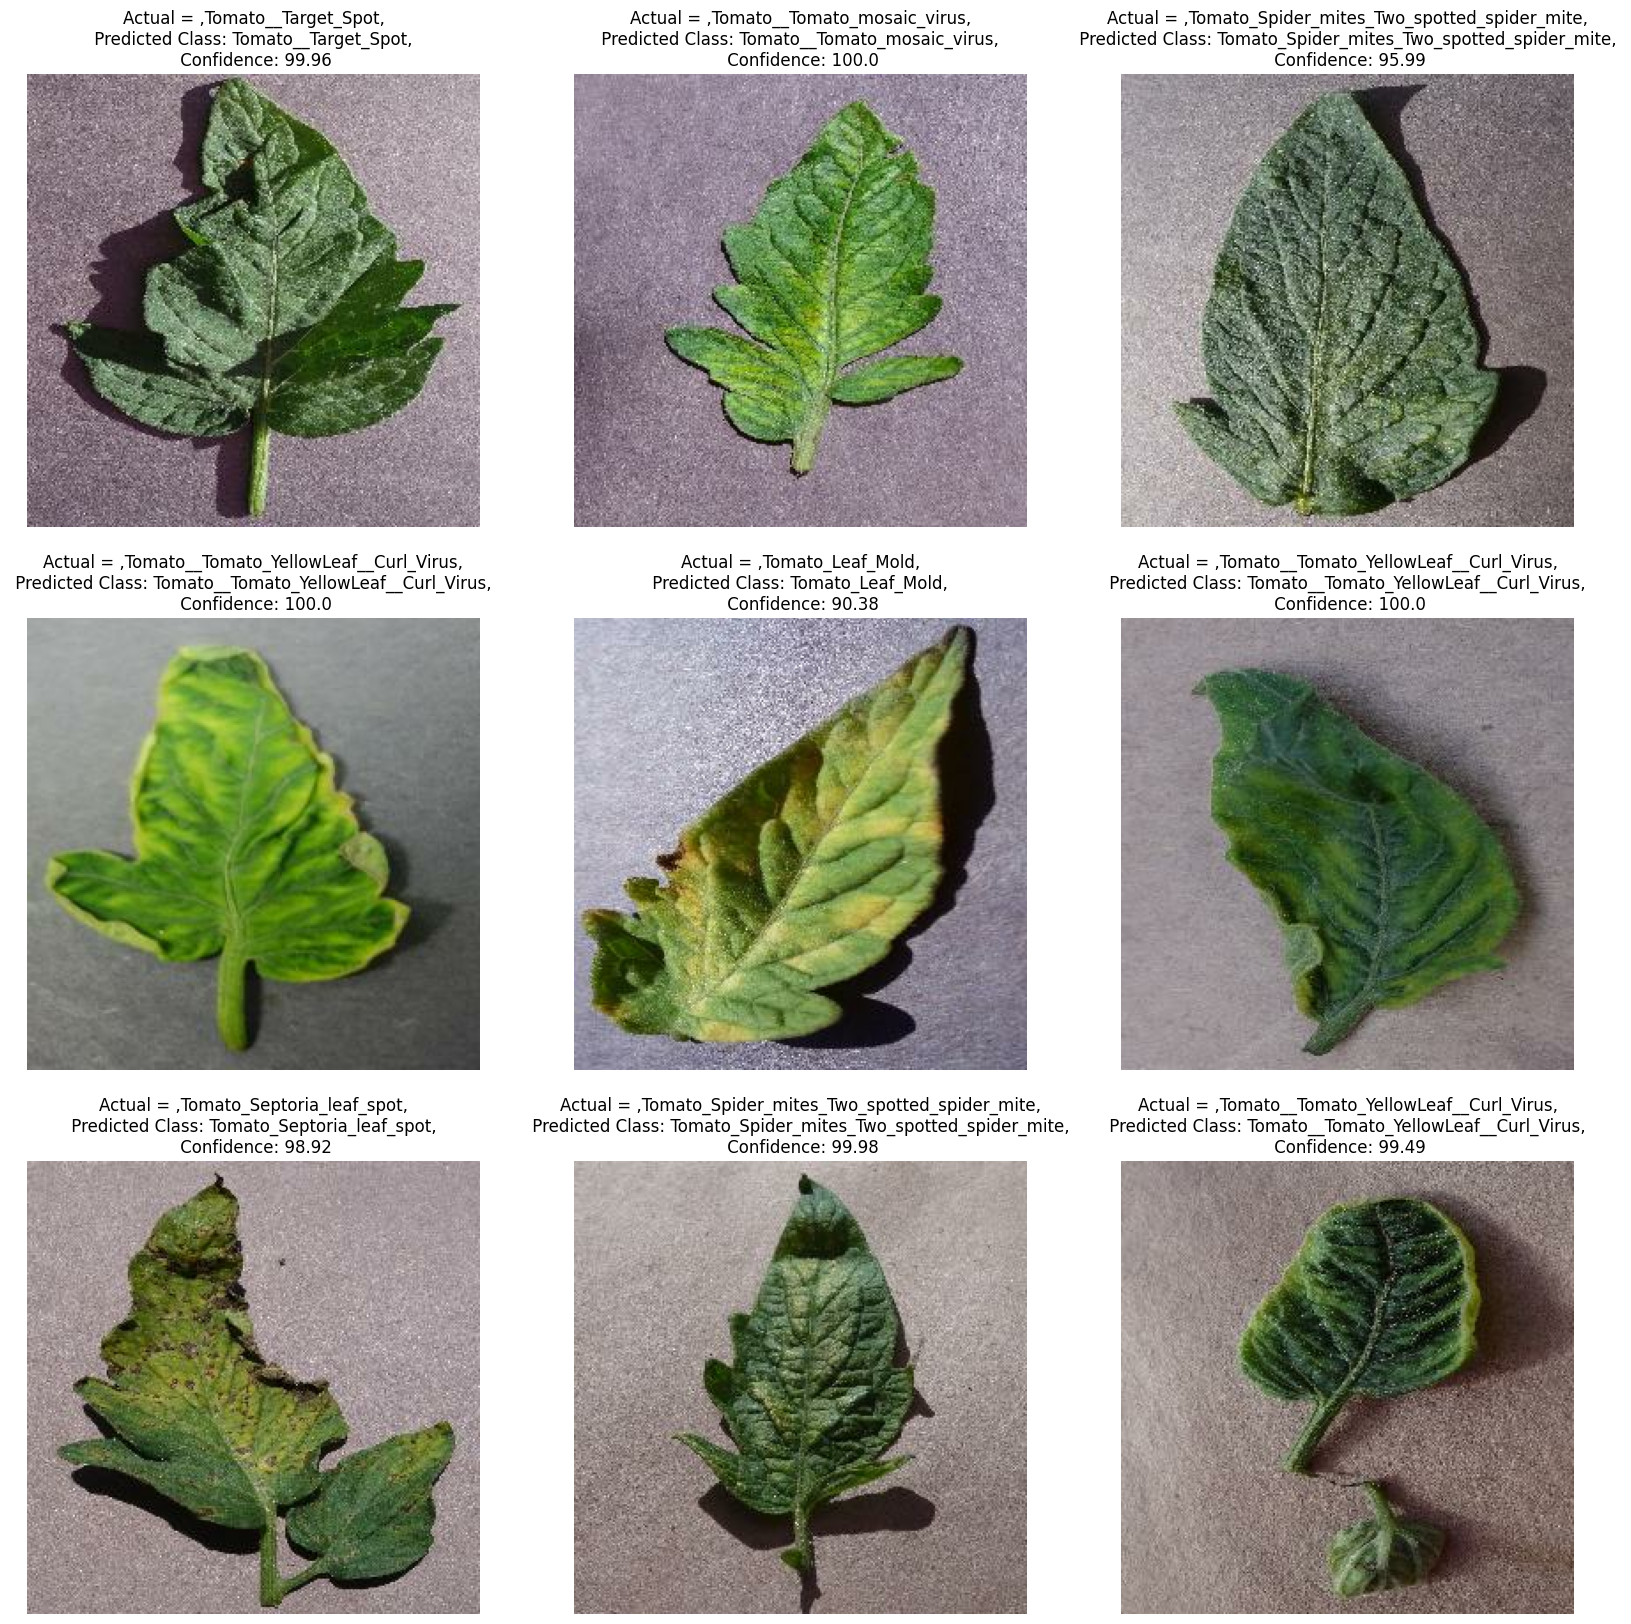

In [54]:
plt.figure(figsize=(20,20))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence=predict(model,images[i].numpy())
        Actual_class=class_Names[labels[i]]
        plt.axis('off')
        plt.title(f'Actual = ,{Actual_class},\n Predicted Class: {predicted_class}, \n Confidence: {confidence}')

#### Saving Our Models Now

> Add blockquote



In [56]:
#model_version = 1
#model.save(f"E:/Python_Data_Science/Tomato_Disease_DL/Project/Training/models/{model_version}.keras")